In [ ]:
# Just run the commands below if you are using colab. Otherwise, don't run.

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os
os.chdir('drive/MyDrive/mestrado/pipeline/scripts')

In [ ]:
def package_installed(package):
  try:
    import package
    print(f"{package} installed")
  except:
    os.system("pip install "+ package)

package_installed("bs4")

NameError: ignored

In [ ]:
import pandas as pd
import regex as re
import itertools
from urllib.request import urlopen
from urllib import parse
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import os

# Load data files

[Table 1 Haplotype and phenotype frequencies of HLA class II alleles](https://link.springer.com/article/10.1007/s00251-011-0513-0/tables/1)

The code below creates the dataframe directly from the table extracted from l's HTML document.

In [ ]:
data = pd.read_html("https://link.springer.com/article/10.1007/s00251-011-0513-0/tables/1")[0]
data.query("Allele != 'Total'", inplace=True)
data.set_index("Locus", inplace=True)

In [ ]:
# data.to_csv("/content/drive/MyDrive/mestrado/files/hla_frequencies.csv")

After saving the table, you can read it directly from the files.

In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/mestrado/files/hla_frequencies.csv', index_col=0)

# Format HLA naming

Modify the nomenclature of HLAs to the conventional format.

http://hla.alleles.org/nomenclature/naming.html

In [ ]:
def nomenclature(alleles):
  alleles = [re.sub(r'(\*{1}\d{2})', r'\1:', allele) for allele in alleles]
  alleles = [allele.replace('/', '-') if allele[0:2]=='DQ' else allele for allele in alleles]
  return alleles

In [ ]:
data['allele_nomenclature'] = nomenclature(data.loc[:,'Allele'])
data

,Allele,Percent of haplotypes,Phenotype frequency,allele_nomenclature
Locus,,,,
DRB1,DRB1*0101,2.8,5.4,DRB1*01:01
DRB1,DRB1*0301,7.1,13.7,DRB1*03:01
DRB1,DRB1*0401,2.3,4.6,DRB1*04:01
DRB1,DRB1*0405,3.1,6.2,DRB1*04:05
DRB1,DRB1*0701,7.0,13.5,DRB1*07:01
DRB1,DRB1*0802,2.5,4.9,DRB1*08:02
DRB1,DRB1*0901,3.1,6.2,DRB1*09:01
DRB1,DRB1*1101,6.1,11.8,DRB1*11:01
DRB1,DRB1*1201,2.0,3.9,DRB1*12:01


# Separate different HLA class II groups

Only the DR and DQ HLAs will be analyzed, as they are the main ones related to autoimmune diseases.

DRB3/4/5 are not listed in the database

https://onlinelibrary.wiley.com/doi/full/10.1002/iid3.416

In [ ]:
path = os.path.join("..", "files", "hla_frequencies.csv")
data.filter(regex=r'D[RQ]', axis=0).to_csv(path)

In [ ]:
DR = data.filter(regex='DRB1', axis=0).copy()
DR

,Allele,Percent of haplotypes,Phenotype frequency,allele_nomenclature
Locus,,,,
DRB1,DRB1*0101,2.8,5.4,DRB1*01:01
DRB1,DRB1*0301,7.1,13.7,DRB1*03:01
DRB1,DRB1*0401,2.3,4.6,DRB1*04:01
DRB1,DRB1*0405,3.1,6.2,DRB1*04:05
DRB1,DRB1*0701,7.0,13.5,DRB1*07:01
DRB1,DRB1*0802,2.5,4.9,DRB1*08:02
DRB1,DRB1*0901,3.1,6.2,DRB1*09:01
DRB1,DRB1*1101,6.1,11.8,DRB1*11:01
DRB1,DRB1*1201,2.0,3.9,DRB1*12:01


In [ ]:
DQ = data.filter(regex='DQ', axis=0).copy()
DQ

,Allele,Percent of haplotypes,Phenotype frequency,allele_nomenclature
Locus,,,,
DQA1/DQB1,DQA1*0501/DQB1*0201,5.8,11.3,DQA1*05:01-DQB1*02:01
DQA1/DQB1,DQA1*0501/DQB1*0301,19.5,35.1,DQA1*05:01-DQB1*03:01
DQA1/DQB1,DQA1*0301/DQB1*0302,10.0,19.0,DQA1*03:01-DQB1*03:02
DQA1/DQB1,DQA1*0401/DQB1*0402,6.6,12.8,DQA1*04:01-DQB1*04:02
DQA1/DQB1,DQA1*0101/DQB1*0501,7.6,14.6,DQA1*01:01-DQB1*05:01
DQA1/DQB1,DQA1*0102/DQB1*0602,7.6,14.6,DQA1*01:02-DQB1*06:02


# Generate HLA pairs

http://www.allelefrequencies.net/hla6003a_scr.asp?hla_selection=A*01-B*08&hla_order=order_3

In [ ]:
alleles_DR = DR['allele_nomenclature'].copy()
alleles_DQ = DQ['allele_nomenclature'].copy()

In [ ]:
def hla_combiner(alleles_DR, alleles_DQ):
  pairs = list(itertools.product(alleles_DR, alleles_DQ))
  return pd.DataFrame({"pairs":["-".join(pair) for pair in pairs]})

In [ ]:
DR_DQ = hla_combiner(alleles_DR, alleles_DQ)

In [ ]:
DR_DQ

,pairs
0,DRB1*01:01-DQA1*05:01-DQB1*02:01
1,DRB1*01:01-DQA1*05:01-DQB1*03:01
2,DRB1*01:01-DQA1*03:01-DQB1*03:02
3,DRB1*01:01-DQA1*04:01-DQB1*04:02
4,DRB1*01:01-DQA1*01:01-DQB1*05:01
...,...
61,DRB1*15:01-DQA1*05:01-DQB1*03:01
62,DRB1*15:01-DQA1*03:01-DQB1*03:02
63,DRB1*15:01-DQA1*04:01-DQB1*04:02
64,DRB1*15:01-DQA1*01:01-DQB1*05:01


# Generate urls to search haplotypes in the *Allele Frequency Net Database*

Exemple
http://www.allelefrequencies.net/hla6003a.asp?hla_selection=DRB1*03:01-DQA1*05:01-DQB1*02:01&hla_order=order_3

The `hla_selection=DRB1*03:01-DQA1*05:01-DQB1*02:01` snippet defines the alleles that must be present in the haplotype.

the `&hla_order=order_3` snippet defines that the selection will be shown in order from the most frequent haplotype to the least.

Font: http://www.allelefrequencies.net/extaccess.asp

In [ ]:
def url_create(pair):
  url_pairt_1 = "http://www.allelefrequencies.net/hla6003a.asp?hla_selection="
  url_pairt_3 = "&hla_order=order_3"
  return "{}{}{}".format(url_pairt_1, pair, url_pairt_3)

In [ ]:
DR_DQ['Haplotype_Search'] = DR_DQ['pairs'].apply(lambda x: url_create(x))

In [ ]:
DR_DQ

,pairs,Haplotype_Search
0,DRB1*01:01-DQA1*05:01-DQB1*02:01,http://www.allelefrequencies.net/hla6003a.asp?...
1,DRB1*01:01-DQA1*05:01-DQB1*03:01,http://www.allelefrequencies.net/hla6003a.asp?...
2,DRB1*01:01-DQA1*03:01-DQB1*03:02,http://www.allelefrequencies.net/hla6003a.asp?...
3,DRB1*01:01-DQA1*04:01-DQB1*04:02,http://www.allelefrequencies.net/hla6003a.asp?...
4,DRB1*01:01-DQA1*01:01-DQB1*05:01,http://www.allelefrequencies.net/hla6003a.asp?...
...,...,...
61,DRB1*15:01-DQA1*05:01-DQB1*03:01,http://www.allelefrequencies.net/hla6003a.asp?...
62,DRB1*15:01-DQA1*03:01-DQB1*03:02,http://www.allelefrequencies.net/hla6003a.asp?...
63,DRB1*15:01-DQA1*04:01-DQB1*04:02,http://www.allelefrequencies.net/hla6003a.asp?...
64,DRB1*15:01-DQA1*01:01-DQB1*05:01,http://www.allelefrequencies.net/hla6003a.asp?...


# Extract data from *The Allele Frequency Net Database*

In [ ]:
def scraping(url):
  response = urlopen(url)
  html = response.read()
  soup = BeautifulSoup(html, 'html.pairser')
  return soup

In [ ]:
def haplotypes_number(url):
  soup = scraping(url)
  table = soup.find('div', {"id":"divGenNavig"})
  try:
    n_haplotypes = table.findAll('td')[0].text
  except:
    return 0
  n_haplotypes = int(re.search(r'(?<=from )\d*', n_haplotypes).group())
  return n_haplotypes

In [ ]:
def haplotype_not_identified(search_result):
  if re.search(r"we did not find any results matching your criteria", search_result.text):
    return True

In [ ]:
def format_url_search(page, url_search):
    pattern = r'(asp\?)'
    substitute = r'\1page={}&'.format(page+1)
    return re.sub(pattern, substitute, url_search)

In [ ]:
def get_data_table(table):
  haplotypes = []
  frequency = []
  sample_size = []

  for line in table:
    data = line.findAll('td')

    haplotypes.append(data[1].find('a').text)
    frequency.append(data[4].text)
    sample_size.append(data[6].text)

  return pd.DataFrame({
      'haplotypes':haplotypes, 'frequency (%)':frequency, 'sample_size':sample_size
      })

In [ ]:
def haplotype_search(lista_urls_pesquisa, pairs):
  haplotypes = pd.DataFrame(
      columns=['pair', 'haplotypes', 'frequency (%)', 'sample_size'])
  for url_search, pair in zip(lista_urls_pesquisa, pairs):

    soup = scraping(url_search)
    search_result = soup.find('div', {"id":"divGenNavig"})

    if haplotype_not_identified(search_result):
      continue

    page_number = search_result.findAll('td')[5].text
    page_number = int(re.search(r'(?<=of )\d*', page_number).group())

    for page in range(1, page_number+1):
      table = soup.find('div', {"id":"divGenDetail"}).find('table', {"class":"tblNormal"}).findAll('tr')[1:]
      result = get_data_table(table)
      result.insert(0, "pair", pair)
      haplotypes = pd.concat([haplotypes, result])
      url_formatted = format_url_search(page, url_search)
      soup = scraping(url_formatted)

  return haplotypes

It takes a long time to run the following commands. Just run it once and then save the dataframe to avoid losing data. The DR_DQ.csv and haplotypes_DR_DQ.csv files are saved in the "files" folder.

In [ ]:
# DR_DQ['haplotypes_number'] = [haplotypes_number(url) for url in DR_DQ['Haplotype_Search']]
# DR_DQ.to_csv("../files/DR_DQ.csv", index=False)

In [ ]:
# DR_DQ.to_csv("DR_DQ.csv")

In [ ]:
# DR_DQ = pd.read_csv("../files/DR_DQ.csv")
# DR_DQ

In [ ]:
# haplotypes_DR_DQ = haplotype_search(DR_DQ.loc[:, 'Haplotype_Search'], DR_DQ.loc[:,'pairs'])
# haplotypes_DR_DQ.to_csv("../files/haplotypes_DR_DQ.csv", index=False)

In [ ]:
# haplotypes_DR_DQ = pd.read_csv('/content/drive/MyDrive/mestrado/files/haplotypes_DR_DQ.csv')

# Haplotype study

## Load data

In [ ]:
DR_DQ = pd.read_csv("../files/DR_DQ.csv")
DR_DQ

,pairs,Haplotype_Search,haplotype_number
0,DRB1*15:01-DQA1*01:02-DQB1*06:02,http://www.allelefrequencies.net/hla6003a.asp?...,348
1,DRB1*01:01-DQA1*01:01-DQB1*05:01,http://www.allelefrequencies.net/hla6003a.asp?...,250
2,DRB1*03:01-DQA1*05:01-DQB1*02:01,http://www.allelefrequencies.net/hla6003a.asp?...,222
3,DRB1*11:01-DQA1*05:01-DQB1*03:01,http://www.allelefrequencies.net/hla6003a.asp?...,123
4,DRB1*08:02-DQA1*04:01-DQB1*04:02,http://www.allelefrequencies.net/hla6003a.asp?...,119
...,...,...,...
61,DRB1*13:02-DQA1*05:01-DQB1*02:01,http://www.allelefrequencies.net/hla6003a.asp?...,0
62,DRB1*01:01-DQA1*05:01-DQB1*03:01,http://www.allelefrequencies.net/hla6003a.asp?...,0
63,DRB1*04:05-DQA1*04:01-DQB1*04:02,http://www.allelefrequencies.net/hla6003a.asp?...,0
64,DRB1*09:01-DQA1*05:01-DQB1*02:01,http://www.allelefrequencies.net/hla6003a.asp?...,0


In [ ]:
DR_DQ.sort_values(by=['pairs'], ascending=False, inplace=True)

In [ ]:
DR_DQ.iloc[0,1]

'http://www.allelefrequencies.net/hla6003a.asp?hla_selection=DRB1*15:01-DQA1*05:01-DQB1*03:01&hla_order=order_3'

In [ ]:
path = os.path.join("..", "files", "haplotypes_DR_DQ.csv")
haplotypes_DR_DQ = pd.read_csv(path)
haplotypes_DR_DQ

,pair,haplotype,frequency (%),sample_size
0,DRB1*01:01-DQA1*05:01-DQB1*02:01,A*31:01:02-B*55:01:01-C*07:01:01-DRB1*01:01:01...,0.3268,153
1,DRB1*01:01-DQA1*05:01-DQB1*02:01,A*02-B*08-DRB1*01:01-DQA1*05:01-DQB1*02:01,0.0780,641
2,DRB1*01:01-DQA1*03:01-DQB1*03:02,A*03:01-B*07:02-C*07:02-DRB1*01:01-DQA1*03:01-...,0.2600,496
3,DRB1*01:01-DQA1*03:01-DQB1*03:02,A*29-B*27-DRB1*01:01-DQA1*03:01-DQB1*03:02,0.0780,641
4,DRB1*01:01-DQA1*03:01-DQB1*03:02,A*24:02-B*52:01-C*12:02-DRB1*01:01-DQA1*03:01-...,0.0700,714
...,...,...,...,...
1406,DRB1*15:01-DQA1*01:02-DQB1*06:02,A*33:03-B*15:01-C*03:03-DRB1*15:01-DQA1*01:02-...,0.0300,"3,078"
1407,DRB1*15:01-DQA1*01:02-DQB1*06:02,A*33:03-B*44:03-C*14:03-DRB1*15:01-DQA1*01:02-...,0.0300,"3,078"
1408,DRB1*15:01-DQA1*01:02-DQB1*06:02,A*33:03-B*44:03-C*14:03-DRB1*15:01-DQA1*01:02-...,0.0300,"3,078"
1409,DRB1*15:01-DQA1*01:02-DQB1*06:02,A*33:03-B*54:01-C*01:02-DRB1*15:01-DQA1*01:02-...,0.0300,"3,078"


## Haplotypes frequency

Haplotypes with frequency less than 1% are rare and will be removed.

https://www.nature.com/articles/s41598-019-42385-6#Sec1

In [ ]:
haplotypes_DR_DQ_filter = haplotypes_DR_DQ.query('`frequency (%)` >= 1').copy()
haplotypes_DR_DQ_filter

,pair,haplotype,frequency (%),sample_size
5,DRB1*01:01-DQA1*01:01-DQB1*05:01,DRB1*01:01-DQA1*01:01-DQB1*05:01,21.40,140
6,DRB1*01:01-DQA1*01:01-DQB1*05:01,DRB1*01:01-DQA1*01:01-DQB1*05:01,10.20,177
7,DRB1*01:01-DQA1*01:01-DQB1*05:01,DRB1*01:01-DQA1*01:01-DQB1*05:01,9.05,"1,899"
8,DRB1*01:01-DQA1*01:01-DQB1*05:01,DRB1*01:01-DQA1*01:01/01:04/01:05-DQB1*05:01,9.00,44
9,DRB1*01:01-DQA1*01:01-DQB1*05:01,DRB1*01:01-DQA1*01:01-DQB1*05:01,8.80,91
...,...,...,...,...
1129,DRB1*15:01-DQA1*01:02-DQB1*06:02,DRB1*15:01-DRB5*01:01-DQA1*01:02-DQB1*06:02-DP...,1.10,220
1130,DRB1*15:01-DQA1*01:02-DQB1*06:02,DRB1*15:01-DRB5*01:01-DQA1*01:02-DQB1*06:02-DP...,1.10,220
1131,DRB1*15:01-DQA1*01:02-DQB1*06:02,DRB1*15:01-DQA1*01:02-DQB1*06:02-DPB1*04:01,1.00,207
1132,DRB1*15:01-DQA1*01:02-DQB1*06:02,DRB1*15:01-DQA1*01:02-DQB1*06:02-DPB1*05:01,1.00,264


## Number of studies that demonstrated the Haplotype

In [ ]:
haplotypes_DR_DQ.shape[0]

1411

In [ ]:
haplotypes_DR_DQ_filter.shape[0]

376

In [ ]:
DR_DQ

,pairs,Haplotype_Search,haplotype_number
34,DRB1*15:01-DQA1*05:01-DQB1*03:01,http://www.allelefrequencies.net/hla6003a.asp?...,2
56,DRB1*15:01-DQA1*05:01-DQB1*02:01,http://www.allelefrequencies.net/hla6003a.asp?...,0
40,DRB1*15:01-DQA1*04:01-DQB1*04:02,http://www.allelefrequencies.net/hla6003a.asp?...,1
33,DRB1*15:01-DQA1*03:01-DQB1*03:02,http://www.allelefrequencies.net/hla6003a.asp?...,2
0,DRB1*15:01-DQA1*01:02-DQB1*06:02,http://www.allelefrequencies.net/hla6003a.asp?...,348
...,...,...,...
36,DRB1*01:01-DQA1*05:01-DQB1*02:01,http://www.allelefrequencies.net/hla6003a.asp?...,2
57,DRB1*01:01-DQA1*04:01-DQB1*04:02,http://www.allelefrequencies.net/hla6003a.asp?...,0
27,DRB1*01:01-DQA1*03:01-DQB1*03:02,http://www.allelefrequencies.net/hla6003a.asp?...,3
28,DRB1*01:01-DQA1*01:02-DQB1*06:02,http://www.allelefrequencies.net/hla6003a.asp?...,3


In [ ]:
haplotypes_DR_DQ_by_pais = haplotypes_DR_DQ["pair"].value_counts().to_frame().reset_index()
haplotypes_DR_DQ_by_pais.rename(columns = {'index':'pair', 'pair':'Contagem'}, inplace = True)
haplotypes_DR_DQ_by_pais.sort_values(by = "Contagem", ascending=False, inplace=True)

In [ ]:
haplotypes_DR_DQ_by_pais['Contagem'].sum()

1411

In [ ]:
haplotypes_DR_DQ_by_pais['Selected Pair'] = ["Yes"
    if Pair in haplotypes_DR_DQ_filter['pair'].unique()
    else "No"
    for Pair in haplotypes_DR_DQ_by_pais['pair']]

In [ ]:
haplotypes_DR_DQ_by_pais

,pair,Contagem,Selected Pair
0,DRB1*15:01-DQA1*01:02-DQB1*06:02,348,Yes
1,DRB1*01:01-DQA1*01:01-DQB1*05:01,250,Yes
2,DRB1*03:01-DQA1*05:01-DQB1*02:01,222,Yes
3,DRB1*11:01-DQA1*05:01-DQB1*03:01,123,Yes
4,DRB1*08:02-DQA1*04:01-DQB1*04:02,119,Yes
5,DRB1*04:01-DQA1*03:01-DQB1*03:02,59,Yes
6,DRB1*12:01-DQA1*05:01-DQB1*03:01,44,Yes
7,DRB1*04:05-DQA1*03:01-DQB1*03:02,40,Yes
8,DRB1*08:02-DQA1*03:01-DQB1*03:02,37,Yes
9,DRB1*11:01-DQA1*01:02-DQB1*06:02,25,Yes


In [ ]:
df1 = haplotypes_DR_DQ_by_pais.query("Contagem > 3").copy()
df2 = haplotypes_DR_DQ_by_pais.query("Contagem <= 3").copy()

In [ ]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.0f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center")
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.0f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left", size=12)

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

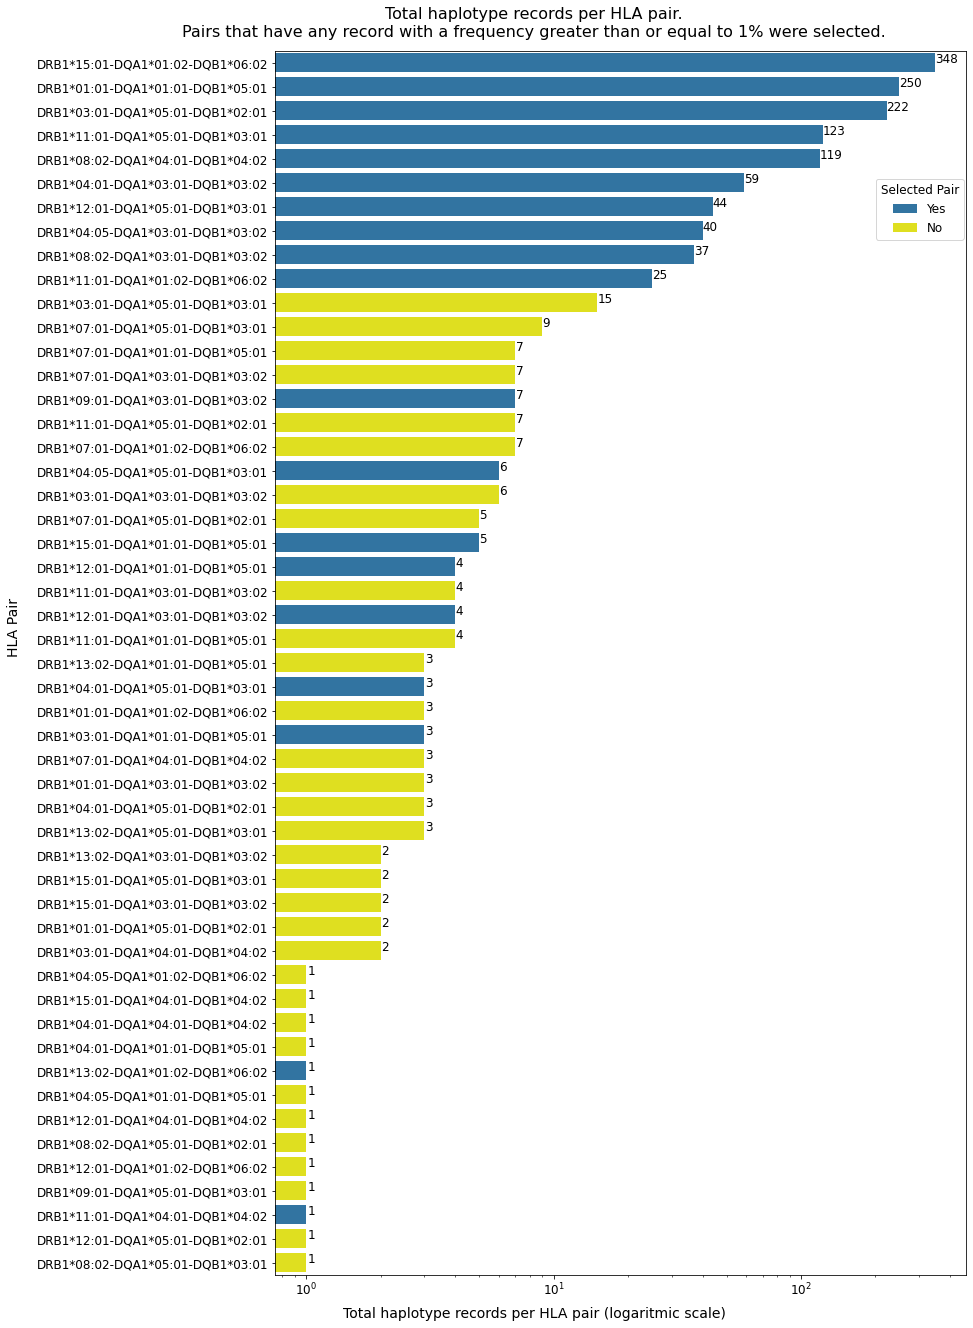

In [ ]:
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

fig, ax1 = plt.subplots(figsize=(12,20))

palette = {"Yes":"C0", "No":"yellow"}

ax = sns.barplot(x="Contagem", y="pair", orient="h", palette=palette,
            hue="Selected Pair", data=haplotypes_DR_DQ_by_pais, ax=ax1, dodge = False)

show_values(axs=ax, orient="h")

ax1.set(xlabel=None)
ax1.set(ylabel=None)

ax1.set_xscale("log")

# https://www.statology.org/seaborn-legend-position/
ax1.legend(bbox_to_anchor=(1.005, 0.9), fontsize=12, title='Selected Pair', title_fontsize=12)

plt.subplots_adjust(left=0.1,
                    bottom=0.05,
                    right=0.9,
                    top=0.9,
                    wspace=1.5, # Horizontal
                    hspace=0.5) # Vertical

fig.text(0.4, 0.02, 'Total haplotype records per HLA pair (logaritmic scale)', ha='center', size=14)
fig.text(-0.21, 0.5, 'HLA Pair', va='center', rotation='vertical', size=14)
fig.text(0.4, 0.91, 'Total haplotype records per HLA pair.\nPairs that have any record with a frequency greater than or equal to 1% were selected.', ha='center', size=16)

plt.savefig('../figures-tables/figure 2.jpg',
            dpi=500, bbox_inches='tight')

plt.show()

## Select HLAs to HLA-binding prediction

In [ ]:
haplotypes_DR_DQ_filter.sort_values('frequency (%)')

,pair,haplotype,frequency (%),sample_size
1133,DRB1*15:01-DQA1*01:02-DQB1*06:02,DRB1*15:01-DQA1*01:02-DQB1*06:02-DPB1*13:01,1.0,207
1052,DRB1*13:02-DQA1*01:02-DQB1*06:02,DRB1*13:02-DQA1*01:02-DQB1*06:02,1.0,101
342,DRB1*03:01-DQA1*05:01-DQB1*02:01,DRB1*03:01-DRB3*01:01-DQA1*05:01-DQB1*02:01-DP...,1.0,220
64,DRB1*01:01-DQA1*01:01-DQB1*05:01,A*11:01-B*27:03-C*01:02-DRB1*01:01-DQA1*01:01-...,1.0,150
1132,DRB1*15:01-DQA1*01:02-DQB1*06:02,DRB1*15:01-DQA1*01:02-DQB1*06:02-DPB1*05:01,1.0,264
...,...,...,...,...
261,DRB1*03:01-DQA1*05:01-DQB1*02:01,DRB1*03:01-DQA1*05:01-DQB1*02:01,22.0,140
260,DRB1*03:01-DQA1*05:01-DQB1*02:01,DRB1*03:01-DQA1*05:01-DQB1*02:01,22.1,91
698,DRB1*08:02-DQA1*04:01-DQB1*04:02,DRB1*08:02-DQA1*04:01-DQB1*04:02,23.0,74
259,DRB1*03:01-DQA1*05:01-DQB1*02:01,DRB1*03:01-DQA1*05:01-DQB1*02:01,23.1,91


In [ ]:
selected_haplotypes = haplotypes_DR_DQ_filter['pair'].drop_duplicates().reset_index(drop=True)
selected_haplotypes

0     DRB1*01:01-DQA1*01:01-DQB1*05:01
1     DRB1*03:01-DQA1*05:01-DQB1*02:01
2     DRB1*03:01-DQA1*01:01-DQB1*05:01
3     DRB1*04:01-DQA1*05:01-DQB1*03:01
4     DRB1*04:01-DQA1*03:01-DQB1*03:02
5     DRB1*04:05-DQA1*05:01-DQB1*03:01
6     DRB1*04:05-DQA1*03:01-DQB1*03:02
7     DRB1*08:02-DQA1*03:01-DQB1*03:02
8     DRB1*08:02-DQA1*04:01-DQB1*04:02
9     DRB1*09:01-DQA1*03:01-DQB1*03:02
10    DRB1*11:01-DQA1*05:01-DQB1*03:01
11    DRB1*11:01-DQA1*04:01-DQB1*04:02
12    DRB1*11:01-DQA1*01:02-DQB1*06:02
13    DRB1*12:01-DQA1*05:01-DQB1*03:01
14    DRB1*12:01-DQA1*03:01-DQB1*03:02
15    DRB1*12:01-DQA1*01:01-DQB1*05:01
16    DRB1*13:02-DQA1*01:02-DQB1*06:02
17    DRB1*15:01-DQA1*01:01-DQB1*05:01
18    DRB1*15:01-DQA1*01:02-DQB1*06:02
Name: pair, dtype: object

In [ ]:
haplotypes_DR_DQ_filter.to_csv("../files/haplotypes_DR_DQ_filter.csv")

In [ ]:
selected_haplotypes = '\n'.join(selected_haplotypes)
selected_haplotypes

'DRB1*01:01-DQA1*01:01-DQB1*05:01\nDRB1*03:01-DQA1*05:01-DQB1*02:01\nDRB1*03:01-DQA1*01:01-DQB1*05:01\nDRB1*04:01-DQA1*05:01-DQB1*03:01\nDRB1*04:01-DQA1*03:01-DQB1*03:02\nDRB1*04:05-DQA1*05:01-DQB1*03:01\nDRB1*04:05-DQA1*03:01-DQB1*03:02\nDRB1*08:02-DQA1*03:01-DQB1*03:02\nDRB1*08:02-DQA1*04:01-DQB1*04:02\nDRB1*09:01-DQA1*03:01-DQB1*03:02\nDRB1*11:01-DQA1*05:01-DQB1*03:01\nDRB1*11:01-DQA1*04:01-DQB1*04:02\nDRB1*11:01-DQA1*01:02-DQB1*06:02\nDRB1*12:01-DQA1*05:01-DQB1*03:01\nDRB1*12:01-DQA1*03:01-DQB1*03:02\nDRB1*12:01-DQA1*01:01-DQB1*05:01\nDRB1*13:02-DQA1*01:02-DQB1*06:02\nDRB1*15:01-DQA1*01:01-DQB1*05:01\nDRB1*15:01-DQA1*01:02-DQB1*06:02'

In [ ]:
alleles_DR = DR['allele_nomenclature']
alleles_DR = pd.Series([allele for allele in alleles_DR.values if allele in selected_haplotypes])
alleles_DR

0    DRB1*01:01
1    DRB1*03:01
2    DRB1*04:01
3    DRB1*04:05
4    DRB1*08:02
5    DRB1*09:01
6    DRB1*11:01
7    DRB1*12:01
8    DRB1*13:02
9    DRB1*15:01
dtype: object

In [ ]:
alleles_DQ = DQ['allele_nomenclature']
alleles_DQ = pd.Series([allele for allele in alleles_DQ.values if allele in selected_haplotypes])
alleles_DQ

0    DQA1*05:01-DQB1*02:01
1    DQA1*05:01-DQB1*03:01
2    DQA1*03:01-DQB1*03:02
3    DQA1*04:01-DQB1*04:02
4    DQA1*01:01-DQB1*05:01
5    DQA1*01:02-DQB1*06:02
dtype: object

In [ ]:
alleles_DR_IEDB = "HLA-" + alleles_DR.values
alleles_DQ_IEDB = "HLA-" + alleles_DQ.str.replace('-', '/').values
alleles = np.append(alleles_DR_IEDB, alleles_DQ_IEDB) + '\n'
alleles = "".join(alleles)
alleles

'HLA-DRB1*01:01\nHLA-DRB1*03:01\nHLA-DRB1*04:01\nHLA-DRB1*04:05\nHLA-DRB1*08:02\nHLA-DRB1*09:01\nHLA-DRB1*11:01\nHLA-DRB1*12:01\nHLA-DRB1*13:02\nHLA-DRB1*15:01\nHLA-DQA1*05:01/DQB1*02:01\nHLA-DQA1*05:01/DQB1*03:01\nHLA-DQA1*03:01/DQB1*03:02\nHLA-DQA1*04:01/DQB1*04:02\nHLA-DQA1*01:01/DQB1*05:01\nHLA-DQA1*01:02/DQB1*06:02\n'

In [ ]:
with open("../files/alleles.txt", 'w') as f:
  f.write(alleles)

In [ ]:
with open("../files/selected_haplotypes.txt", 'w') as f:
  f.write(selected_haplotypes)